**이 문서의 코드는 KUBIG 2021-2 딥러닝 NLP 소대회 전처리 및 모델링 코드 정리 및 작동 편의를 위해 작성된 것으로,  
세부적인 테스트와 주석 및 파라미터 튜닝 과정은 생략함에 유의할 것**
- 대회 소개: https://dacon.io/competitions/official/235747/overview/description 

# **Setup**

### 필요한 패키지, 글꼴 설치

In [1]:
# 나눔글꼴 설치 (시각화에서 한글 깨짐 현상 방지): 다운로드 후 런타임 재시작 필요
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [2]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 28.4 MB/s 
     |████████████████████████████████| 86 kB 4.3 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [3]:
!pip install kiwipiepy

     |████████████████████████████████| 495 kB 5.0 MB/s 
     |████████████████████████████████| 25.7 MB 61 kB/s 
  Created wheel for kiwipiepy-model: filename=kiwipiepy_model-0.10.0-py3-none-any.whl size=25882656 sha256=89e78081826b018c8e888b8899a168aa21f7f34a30bf7df557c4c0cc6fa94fdd
  Stored in directory: /root/.cache/pip/wheels/42/2f/c9/c82156eb15ed5ebb5475002723d1ab319947aca25bd663cd1d
Successfully built kiwipiepy-model


In [4]:
!pip install soynlp

     |████████████████████████████████| 416 kB 5.1 MB/s 


In [5]:
!pip install wordcloud

### 패키지 불러오기 & 구글 드라이브 mount

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kiwipiepy import Kiwi, Option
from soynlp.word import WordExtractor
from nltk import Text
from matplotlib import font_manager, rc
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **데이터 로드 및 EDA**

## **1) 데이터 로드 및 train/test data 분리**

In [8]:
data = pd.read_csv('/content/drive/MyDrive/KUBIG 2021-2/데이터분석대회/dataset/train_data.csv')
Test_data = pd.read_csv('/content/drive/MyDrive/KUBIG 2021-2/데이터분석대회/dataset/test_data.csv')

In [9]:
data

index                               title  topic_idx
0          0            인천→핀란드 항공기 결항…휴가철 여행객 분통          4
1          1      실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화          4
2          2      이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것          4
3          3    NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합          4
4          4           시진핑 트럼프에 중미 무역협상 조속 타결 희망          4
...      ...                                 ...        ...
45649  45649        KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략          1
45650  45650     1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토          2
45651  45651         게시판 키움증권 2020 키움 영웅전 실전투자대회          1
45652  45652                   답변하는 배기동 국립중앙박물관장          2
45653  45653  2020 한국인터넷기자상 시상식 내달 1일 개최…특별상 김성후          2

[45654 rows x 3 columns]

In [10]:
Test_data

index                            title
0     45654       유튜브 내달 2일까지 크리에이터 지원 공간 운영
1     45655          어버이날 맑다가 흐려져…남부지방 옅은 황사
2     45656      내년부터 국가RD 평가 때 논문건수는 반영 않는다
3     45657  김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4     45658   회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간
...     ...                              ...
9126  54780     인천 오후 3시35분 대설주의보…눈 3.1cm 쌓여
9127  54781    노래방에서 지인 성추행 외교부 사무관 불구속 입건종합
9128  54782     40년 전 부마항쟁 부산 시위 사진 2점 최초 공개
9129  54783    게시판 아리랑TV 아프리카개발은행 총회 개회식 생중계
9130  54784  유영민 과기장관 강소특구는 지역 혁신의 중심…지원책 강구

[9131 rows x 2 columns]

In [11]:
# 중복 데이터 확인
print(data['title'].nunique(), data['topic_idx'].nunique()) 
print(Test_data['title'].nunique())

45654 7
9131


In [12]:
# 결측치 확인
print(data.isnull().values.any())
print(Test_data.isnull().values.any())

False
False


In [13]:
# 훈련 데이터 순서 섞기 (shuffle): 클래스 골고루 섞이게
indices = np.arange(data.shape[0])
np.random.seed(5)
np.random.shuffle(indices)
print(indices)

[15780  1035 28358 ... 20463 18638 35683]


In [14]:
data = data.iloc[indices].reset_index(drop=True)

In [15]:
data

index                             title  topic_idx
0      15780  U20월드컵 이탈리아 우승후보 프랑스 꺾고 8강 진출...          5
1       1035       카카오프렌즈가 나간다…프렌즈 게임 퍼블리싱 본격화          0
2      28358         종근당홀딩스 2분기 영업익 60억원…527%↑          1
3      37717      광명전기 181억원 규모 원전 전동기제어반 공급계약          1
4      38990   일하다 죽지 않게 차별받지 않게…이달 22일 희망버스종합          2
...      ...                               ...        ...
45649   5520        주간 화제의 뉴스 국정농단 재판 이국종 등 관심          2
45650  35814       임종석 문재인정부서 사찰행위는 존재하지 않는다종합          6
45651  20463      대한항공·현대캐피탈 FA 대어 정지석·문성민 잡는다          5
45652  18638   정부 北 8·25 합의 되새기고 핵개발·대남도발 중단해야          6
45653  35683  베트남 3대 대도시 주민 복수비자 발급대상 영주권자로 제한          4

[45654 rows x 3 columns]

In [16]:
# data를 3:1 비율로 분리(train/test)
train_data, test_data = train_test_split(data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 34240
테스트용 리뷰의 개수 : 11414


## **2) 데이터 레이블 분포 확인**

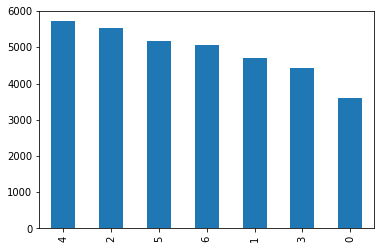

In [17]:
# train_data 레이블의 분포 확인
train_data['topic_idx'].value_counts().plot(kind = 'bar')  

In [18]:
print(train_data.groupby('topic_idx').size().reset_index(name = 'count'))

   topic_idx  count
0          0   3600
1          1   4703
2          2   5537
3          3   4431
4          4   5716
5          5   5178
6          6   5075


# **데이터 전처리**
- 중간에 5번 항목에 시각화랑 EDA 일부 포함되어 있음

## **3) 데이터 정제하기**

In [19]:
# 한글, 영어, 한자, 숫자 제외한 나머지 제거
def elimCharacter(data, mode='Train'):
  data['title'] = data['title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9一-龥 ]","")
  if mode=='Train':
    data.drop_duplicates(subset = ['title'], inplace=True) # 중복 제거
    data['title'].replace('', np.nan, inplace=True) # 공백은 NaN값으로 변환
    data = data.dropna(how='any') # 결측치 제거
  print('전처리 후 샘플의 개수 :',len(data))
  print('\n----- Eliminated unmeaningful characters -----\n')
  
  return data 

## **4) 토큰화 및 불용어 제거**

### **(1) 형태소 분석기(tokenizer)에 (고유)명사 사전추가: Kiwi 패키지 활용**
- 그냥 형태소 분석 진행하게 되면 고유명사가 잘못 분석되는 경우가 발생함  
ex) 김정은 -> 김정, 은

#### **Kiwi 패키지 활용하여 코퍼스로부터 미등록 단어 추출 및 사전 등록** 
- 단어점수(score) 선택 기준은 전처리 풀버전 코드의 soynlp 참고

In [20]:
# 미등록 단어 추출 및 일부 등록
def regisVocab(data):
  # 미등록 단어 추출 및 리스트 확인
  kiwi = Kiwi()
  inputs = list(data['title'])
  extracted_list = kiwi.extract_words(inputs, min_cnt=2, max_word_len=10, min_score=0.1)
  extracted_list.sort(key=lambda x: (-x[1], -x[2]))
  print('단어점수, 빈도수를 기준으로 정렬한 미등록 단어 리스트: ', extracted_list)

  # 고유명사(NNP) 사전등록: '아르헨'을 제외하고는 단어점수를 높게 설정(score=3)
  NNP_list = ['아가메즈', '정의용', '서훈', '김성균', '천해성', '윤건영', '조명균', '윤영찬', '후안 포이스', 
              '랴오닝', '샌프란시스코', '우즈베크', '삼성라이온즈', '탬파베이', 'IBK기업은행', '버라이즌', '아이폰XS', '메타세쿼이아']
  for item in NNP_list:
    kiwi.add_user_word(item, 'NNP', 3)
  kiwi.add_user_word('아르헨', 'NNP') # score = 0 (default)

  # 일반명사(NNG) 사전등록: 전부 단어점수를 높게 설정(score=3)
  NNG_list = ['현대미술', '소상공인', '현대무용', '임대주택', '사전예약', '4차산업혁명', '자율주행']
  for item in NNG_list:
    kiwi.add_user_word(item, 'NNG', 3)
  
  print('----- Extracted and Registered unregistered vocab -----\n')
  
  return kiwi

### **(2) 토큰화 진행 및 품사 기준 불용어 제거: Kiwi 선택**
- Kiwi 선택: Mecab보다 고유명사 사전등록 상태 및 토큰화 성능이 우수한 것으로 판단
- 품사 태그 목록 확인: https://github.com/bab2min/kiwipiepy 

In [21]:
# 토큰화 및 품사 기준 불용어 제거
def tokenization(data, tokenizer):
  pos_list = ['NNG', 'NNP', 'NNB', 'NR', 'VV', 'VA', 'VX', 'VCN', 'MM', 'MAG', 'IC', 'XPN', 'XR', 'SL', 'SH']  # 보존할 품사 리스트

  X = []
  for result in tokenizer.analyze(list(data['title'])):
    result_sliced = result[0][0]
    temp = []
    for token in result_sliced:
      if token[1] in pos_list:
        temp.append(token[0])
    X.append(temp)

  data['tokenized'] = X
  print('----- Tokenization finished -----\n')
  
  return data

### **(3) 불용어 지정 및 제거**
- EDA: **각 토픽별 빈도수 상위 100/200 단어의 교집합 확인**
- 교집합 단어 중 일부를 제외하고 전부 불용어 사전으로 지정
- **top 200 ~ 300 이상까지 체크해보기**
- **불용어 제거 아이디어: EDA 결과로 나온 공통 단어(교집합)가 등장하는 문장을 한번에 뽑아내는 코드를 짜서 쉽게 확인해보기!!**  
  -> 나온 단어, 문장들을 **토픽별로 빈도 세보기** (보민님)

#### **EDA: 추가적인 불용어 사전 제거 이전** 훈련 데이터 분포 확인 (품사 기준 제거만 한 상태)


In [22]:
def search_CommonToken(data):
  # 각 토픽별 단어 리스트 저장
  words_list = []
  for i in range(7):
    words = np.hstack(data[data.topic_idx == i]['tokenized'].values)
    words_list.append(words)
  
  # 각 토픽별 단어 개수 세기
  words_cnt_list = []
  for words in words_list:
    words_cnt = Counter(words)
    words_cnt_list.append(words_cnt)
  
  # 각 토픽별 빈도수 상위 20 단어 출력
  i = 0
  topic_list = ['IT과학', '경제', '사회', '생활문화', '세계', '스포츠', '정치']
  for words_cnt in words_cnt_list:
    print(topic_list[i]+' 빈도수 Top 20 단어: ', words_cnt.most_common(20))
    i += 1

  # 모든 토픽의 공통단어 전체 리스트
  words_set = list(map(lambda x: set(x), words_list))
  words_intersection = list(words_set[0] & words_set[1] & words_set[2] & words_set[3] & words_set[4] & words_set[5] & words_set[6])
  print('모든 토픽의 전체 공통 단어: ', words_intersection)
  print('모든 토픽의 공통 단어 전체 개수: ', len(words_intersection))

  # 각 토픽별 빈도수 상위 100/200 단어 리스트 저장
  top100_words = []
  for words_cnt in words_cnt_list:
    top100_words.append(set(list(map(lambda x: x[0], words_cnt.most_common(100)))))

  top200_words = []
  for words_cnt in words_cnt_list:
    top200_words.append(set(list(map(lambda x: x[0], words_cnt.most_common(200)))))
  
  # 모든 토픽의 빈도수 상위 100/200 공통 단어
  top100_intersection = list(top100_words[0] & top100_words[1] & top100_words[2] & top100_words[3] & top100_words[4] & top100_words[5] & top100_words[6]) 
  print('모든 토픽의 빈도수 상위 100 공통 단어: ', top100_intersection)

  top200_intersection = list(top200_words[0] & top200_words[1] & top200_words[2] & top200_words[3] & top200_words[4] & top200_words[5] & top200_words[6])
  print('모든 토픽의 빈도수 상위 200 공통 단어: ', top200_intersection)

  print('모든 토픽의 빈도수 상위 100-200 공통단어: ', set(top200_intersection) - set(top100_intersection))

  print('\n----- Searched common tokens in all topic labels -----\n')

  return topic_list

#### **불용어 지정 및 제거**

In [23]:
# 추가 불용어 제거
def dropStopwords(data):
  my_stopwords = ['종합', '년', '월', '일', '명', '대', '등', '만', '한', 
                  '것', '개', '지', '보', '위', '전', '첫', '새', '주', '원', '안', '없', '하']
  data['tokenized'] = data['tokenized'].apply(lambda x: [item for item in x if item not in set(my_stopwords)]) 
  print('----- Eliminated my stopwords -----\n') 

  return data

## **5) 단어와 길이 분포 확인/시각화**

In [24]:
# 단어 빈도 분포 시각화
def vocab_freqdist(data, topic_list=None, mode='Train'):
    # train, Test data의 빈도수 상위 20 단어 출력  
    total_words_list = np.hstack(data['tokenized'].values)
    total_words_cnt = Counter(total_words_list)
    print(mode, ' data frequency Top 20 words: ', total_words_cnt.most_common(20))  # Train mode의 train_data, Test mode 데이터만 확인
    
    # train_data에 대한 워드 클라우드 생성
    if mode == 'Train':
      # 각 토픽별 단어 리스트 다시 저장
      words_list = []
      for i in range(7):
        words = np.hstack(data[data.topic_idx == i]['tokenized'].values)
        words_list.append(words)      
    
      Text_data_list = []
      for words in words_list:
        Text_data = Text(words).vocab().most_common(100)
        Text_data_list.append(Text_data)
      
      plt.rc('font', family='NanumBarunGothic') 
      path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
      wc = WordCloud(font_path = path, background_color = 'white')

      fig = plt.figure(figsize=(40,40))
      plt.rcParams.update({'font.size': 22})

      for i in range(1, 8):
        ax = fig.add_subplot(4,2,i)
        wc.generate_from_frequencies(dict(Text_data_list[i-1]))
        ax.set_title(topic_list[i-1])
        ax.imshow(wc)
        ax.axis('off')
      
      plt.show()
      print('----- Visualized frequency distribution of vocab -----\n')

In [25]:
# 단어 길이 분포 시각화
def vocab_lendist(data1, data2):
  plt.rcParams.update({'font.size': 12})
  fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
  text_len = data1['tokenized'].map(lambda x: len(x))
  ax1.hist(text_len, color='red')
  ax1.set_title('train data titles')
  ax1.set_xlabel('length of samples')
  ax1.set_ylabel('number of samples')
  print('train data title 평균 길이 :', np.mean(text_len))
  
  text_len = data2['tokenized'].map(lambda x: len(x))
  ax2.hist(text_len, color='blue')
  ax2.set_title('Test data titles')
  fig.suptitle('Words in texts')
  ax2.set_xlabel('length of samples')
  ax2.set_ylabel('number of samples')
  print('Test data title 평균 길이 :', np.mean(text_len))
  plt.show()

  print('----- Visualized length distribution of vocab -----\n')

## **6) 정수 인코딩**

In [26]:
# 정수 인코딩
def intEncoding(X_train, y_train, X_test, y_test, X_Test):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(X_train)
  
  # 빈도수 1회인 희귀 단어 확인 및 제외
  threshold = 2
  total_cnt = len(tokenizer.word_index) # 단어의 수
  rare_cnt = 0 # 빈도수 1회 단어의 수
  total_freq = 0 # 전체 단어의 빈도수 총합
  rare_freq = 0 # 빈도수 1회 단어의 빈도수의 총합

  for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

  print('단어 집합(vocabulary)의 크기 :',total_cnt)
  print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
  print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
  print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

  vocab_size = total_cnt - rare_cnt + 2
  print('단어 집합의 크기 제한 :',vocab_size)

  tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')  
  tokenizer.fit_on_texts(X_train)

  X_train = tokenizer.texts_to_sequences(X_train)
  X_test = tokenizer.texts_to_sequences(X_test)
  X_Test = tokenizer.texts_to_sequences(X_Test)
  
  # 빈 샘플 제거
  drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
  X_train = np.delete(X_train, drop_train, axis=0)
  y_train = np.delete(y_train, drop_train, axis=0)

  drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]
  X_test = np.delete(X_test, drop_test, axis=0)
  y_test = np.delete(y_test, drop_test, axis=0)

  print('----- Finished integer encoding -----\n')

  return X_train, y_train, X_test, y_test, X_Test

## **7) 패딩**

In [27]:
# 패딩
def padding(X_train, X_test, X_Test):
  # 훈련 데이터 길이 분포 확인
  print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
  print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
  plt.hist([len(s) for s in X_train], bins=50)
  plt.xlabel('length of samples')
  plt.ylabel('number of samples')
  plt.show()

  # 최대 길이로 패딩하기
  X_train = pad_sequences(X_train, maxlen = 16)
  X_test = pad_sequences(X_test, maxlen = 16)
  X_Test = pad_sequences(X_Test, maxlen = 16)

  print('----- Finished padding -----\n')

  return X_train, X_test, X_Test

## **train_data, test_data, Test_data(실제 테스트 데이터) 전처리 및 EDA 함수 적용**
- 반드시 순서대로 실행할 것



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

전처리 후 샘플의 개수 : 34228

----- Eliminated unmeaningful characters -----

전처리 후 샘플의 개수 : 11412

----- Eliminated unmeaningful characters -----

전처리 후 샘플의 개수 : 9131

----- Eliminated unmeaningful characters -----

단어점수, 빈도수를 기준으로 정렬한 미등록 단어 리스트:  [('천500', 0.4138369560241699, 44, -2.9084670543670654), ('시청자미디어센터', 0.38394656777381897, 6, -2.948953151702881), ('아가메즈', 0.28421348333358765, 28, -2.873833417892456), ('조8천억원', 0.28257834911346436, 8, -1.6972545385360718), ('랴오닝', 0.2743195593357086, 10, -1.2287330627441406), ('천600억원', 0.27293601632118225, 8, -2.504289388656616), ('9만9천', 0.26427605748176575, 10, -2.824367046356201), ('원아시아페스티벌', 0.26148679852485657, 4, -1.434594988822937), ('현대미술', 0.25145596265792847, 43, -0.5146864652633667), ('학교비정규직', 0.23075108230113983, 7, -0.6998279690742493), ('학교비정규직연대', 0.20200978219509125, 3, -1.5213700532913208), ('조7천억', 0.19502465426921844, 9, -2.7199881076812744), ('우즈베크', 0.1930171251296997, 22, -1.759033441543579), ('꽁꽁', 0.18822990357875824, 1

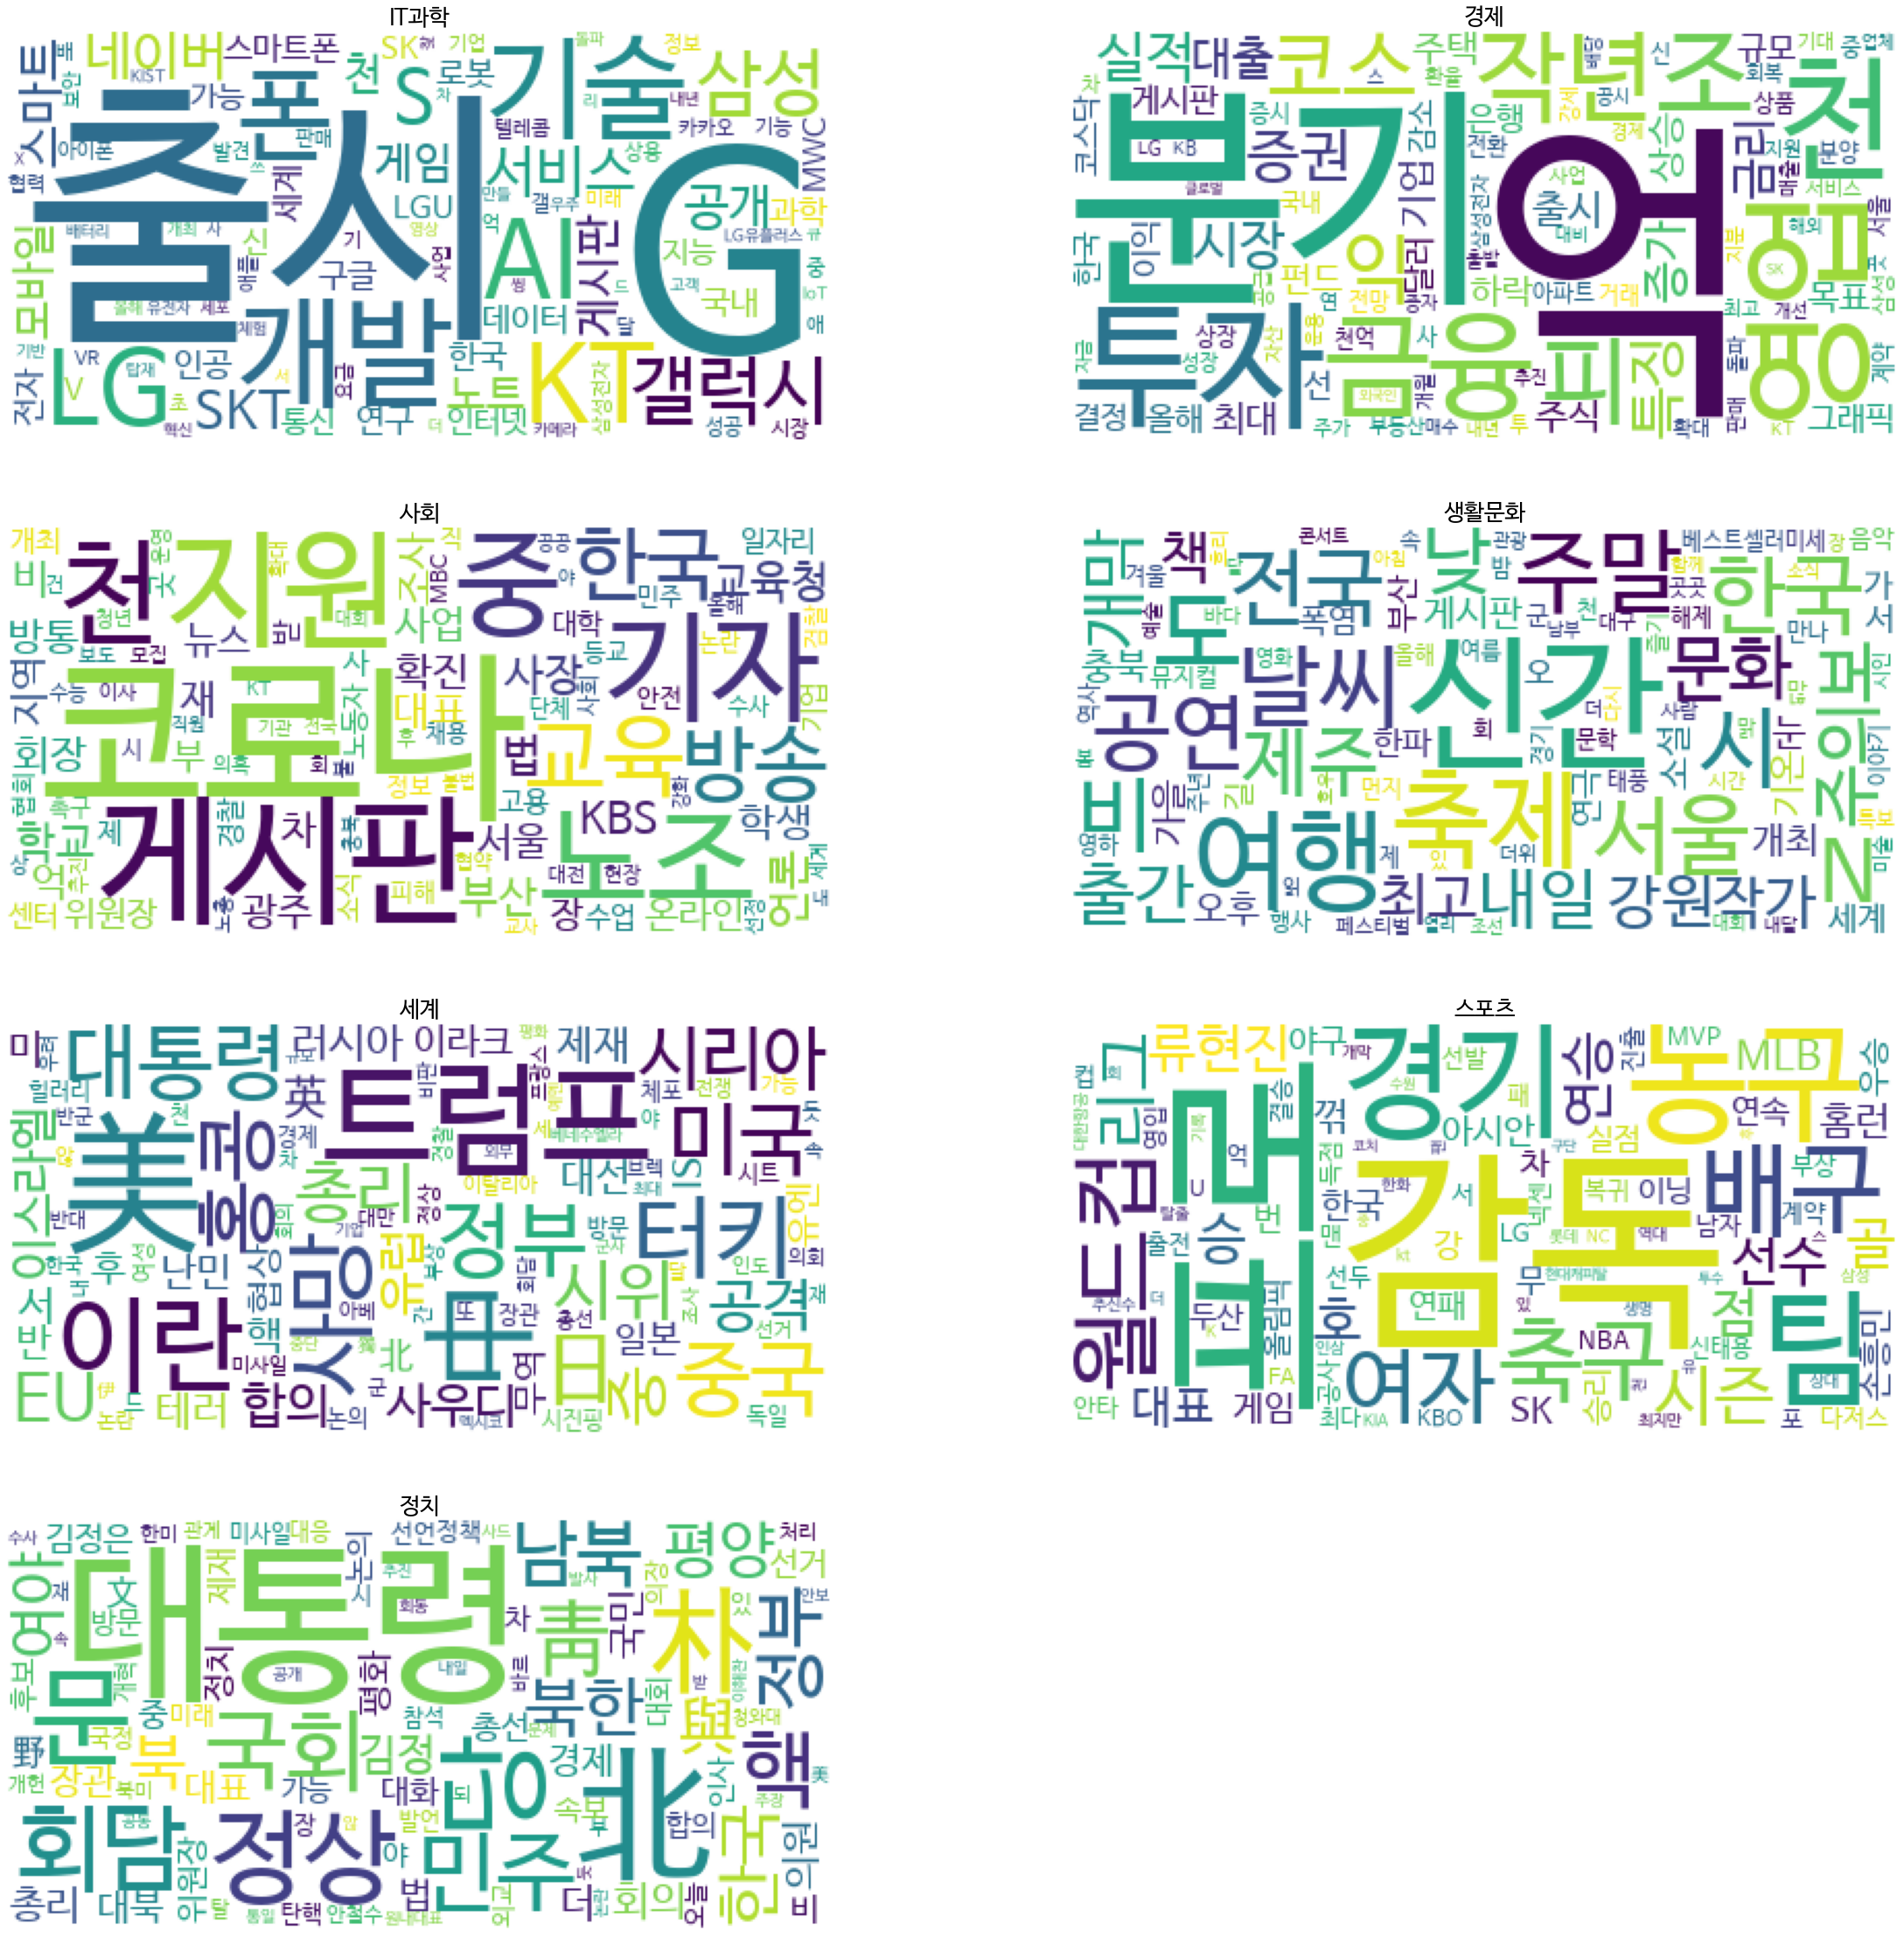

----- Visualized frequency distribution of vocab -----

Test  data frequency Top 20 words:  [('대통령', 374), ('美', 286), ('北', 285), ('억', 262), ('한국', 253), ('천', 235), ('게시판', 191), ('G', 159), ('트럼프', 157), ('중', 157), ('감독', 155), ('프로', 150), ('출시', 149), ('中', 146), ('대표', 145), ('당', 144), ('朴', 143), ('경기', 139), ('시', 138), ('팀', 132)]
train data title 평균 길이 : 8.230308519340891
Test data title 평균 길이 : 8.216515168108641


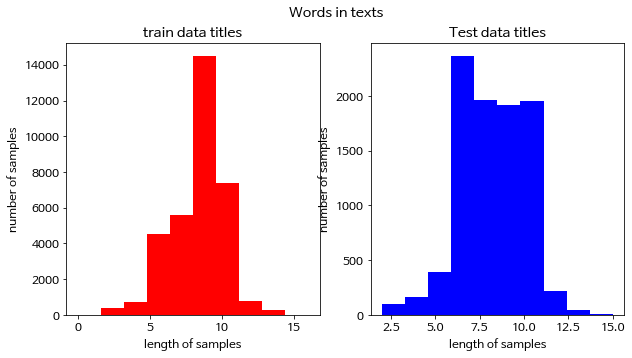

----- Visualized length distribution of vocab -----

단어 집합(vocabulary)의 크기 : 25648
등장 빈도가 1번 이하인 희귀 단어의 수: 11101
단어 집합에서 희귀 단어의 비율: 43.2821272613849
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.9406191539436364
단어 집합의 크기 제한 : 14549


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


----- Finished integer encoding -----

리뷰의 최대 길이 : 16
리뷰의 평균 길이 : 8.230548981797996


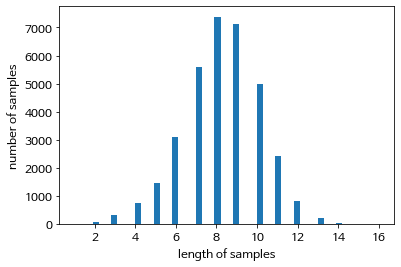

----- Finished padding -----



In [28]:
# 데이터 정제(필요없는 문자 제거)
train_data = elimCharacter(train_data)
test_data = elimCharacter(test_data)
Test_data = elimCharacter(Test_data, mode='Test')

# 명사 사전 등록
kiwi = regisVocab(train_data)

# 토큰화(품사기준 불용어 제거)
train_data = tokenization(train_data, kiwi)
test_data = tokenization(test_data, kiwi)
Test_data = tokenization(Test_data, kiwi)

# 모든 토픽의 공통 단어 확인
topic_list = search_CommonToken(train_data)

# 불용어 지정 및 제거
train_data = dropStopwords(train_data)
test_data = dropStopwords(test_data)
Test_data = dropStopwords(Test_data)

# 단어 빈도수 분포 확인 및 시각화
vocab_freqdist(train_data, topic_list=topic_list)
vocab_freqdist(Test_data, mode='Test')

# 단어 길이 분포 확인 및 시각화
vocab_lendist(train_data, Test_data)

# # X, y 분리 (텍스트와 라벨 분리)
X_train = train_data['tokenized'].values
y_train = train_data['topic_idx'].values
X_test= test_data['tokenized'].values
y_test = test_data['topic_idx'].values
X_Test = Test_data['tokenized'].values

# 정수인코딩
X_train, y_train, X_test, y_test, X_Test = intEncoding(X_train, y_train, X_test, y_test, X_Test)

# 패딩
X_train, X_test, X_Test = padding(X_train, X_test, X_Test)

# **데이터 저장**

In [29]:
np.save('/content/drive/MyDrive/KUBIG 2021-2/데이터분석대회/전처리 완료 데이터_ver2(함수화 버전)/X_train', X_train)
np.save('/content/drive/MyDrive/KUBIG 2021-2/데이터분석대회/전처리 완료 데이터_ver2(함수화 버전)/X_test', X_test)
np.save('/content/drive/MyDrive/KUBIG 2021-2/데이터분석대회/전처리 완료 데이터_ver2(함수화 버전)/y_train', y_train)
np.save('/content/drive/MyDrive/KUBIG 2021-2/데이터분석대회/전처리 완료 데이터_ver2(함수화 버전)/y_test', y_test)
np.save('/content/drive/MyDrive/KUBIG 2021-2/데이터분석대회/전처리 완료 데이터_ver2(함수화 버전)/X_Test', X_Test)